# Identifying Safe Loans with Decision Trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use DataFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

# Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import string
import graphviz 
from os import system
from IPython.display import Image
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Load LendingClub dataset

Load the dataset into a data frame named loans

In [2]:
loans = pd.read_csv('lending-club-data.csv')

c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

Here, we should see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called **bad_loans**. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called **safe_loans**.

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

Now, let us explore the distribution of the column safe_loans. This gives us a sense of how many safe and risky loans are present in the dataset. Print out the percentage of safe loans and risky loans in the data frame.

In [5]:
percentage_safe_loans = sum(loans['safe_loans'] == 1)/ len(loans) * 100
percentage_risky_loans = sum(loans['safe_loans'] == -1) /len(loans) * 100

print('Percentage of safe loans : ', round(percentage_safe_loans,0))
print('Percentage of risky loans : ', round(percentage_risky_loans,0))

Percentage of safe loans :  81.0
Percentage of risky loans :  19.0


You should have:

* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features. Extract these feature columns and target column from the dataset. We will only use these features.


In [6]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a subset of features and the target that we will use for the rest of this notebook.

## One Hot Encoding

In [7]:
catergorical_vars = [var for var in loans.columns if loans[var].dtypes == object]
loans = pd.get_dummies(loans)

## Split data into training and validation sets

We split the data into training and validation sets using the indexes from the json files provided

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [8]:
train_indices = pd.read_json('module-5-assignment-1-train-idx.json')
train_indices = train_indices.rename({0: 'indices'}, axis=1)
train_indices = list(train_indices['indices'])

validation_indices = pd.read_json('module-5-assignment-1-validation-idx.json')
validation_indices = validation_indices.rename({0: 'indices'}, axis=1)
validation_indices = list(validation_indices['indices'])

train_data = loans.iloc[train_indices]
validation_data = loans.iloc[validation_indices]

# Build a decision tree classifier

Now, let's use the built-in scikit learn decision tree learner (sklearn.tree.DecisionTreeClassifier) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

**Note:** You will have to first convert the DataFrame into a numpy data array, and extract the target labels as a numpy array (Hint: you can use the **.to_numpy()** method call on DataFrame to turn DataFrames into numpy arrays). See the API for more information. **Make sure to set max_depth=6**.

Call this model **decision_tree_model**

In [9]:
train_matrix = train_data.drop('safe_loans', axis=1)
train_label = train_data['safe_loans'].to_numpy()

decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(train_matrix, train_label)

small_model = DecisionTreeClassifier(max_depth=2)
small_model = small_model.fit(train_matrix, train_label)

## Visualizing a learned model (Optional)

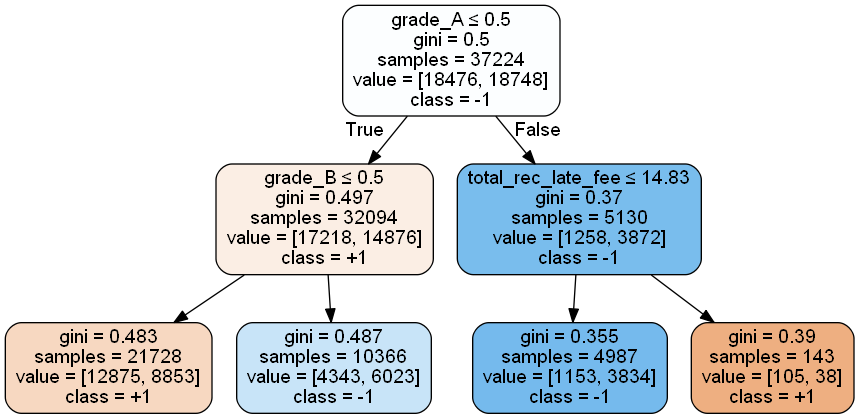

In [10]:
dot_data = tree.export_graphviz(small_model, out_file='simple_tree.dot',
                               feature_names=train_matrix.columns,  
                         class_names=['+1','-1'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
system("dot -Tpng simple_tree.dot -o simple_tree.png")

Image(filename='simple_tree.png')

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:

* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

First, let's grab 2 positive examples and 2 negative examples

In [11]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


Now, we will use our model to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. (Hint: if you are using scikit-learn, you can use the **.predict()** method)

In [12]:
sample_validation_data_matrix = sample_validation_data.drop('safe_loans', axis=1)
sample_validation_data_label = sample_validation_data['safe_loans'].to_numpy()

sample_validation_data_predictions = decision_tree_model.predict(sample_validation_data_matrix)

# The code below is to answer the following quiz quesiton

sample_validation_accuracy = decision_tree_model.score(sample_validation_data_matrix, sample_validation_data_label)
print('The decision_tree_model got', sample_validation_accuracy * 100, 
      '% predictions correct for the sample_validation_data')

The decision_tree_model got 50.0 % predictions correct for the sample_validation_data


<font color='steelblue'><b> Quiz : What percentage of the predictions on sample_validation_data did decision_tree_model get correct? </b></font>

<font color='mediumvioletred'><b> Answer : The decision_tree_model got {{sample_validation_accuracy * 100}} % correct predictions for the sample_validation_data </b></font>

## Explore label predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? (Hint: if you are using scikit-learn, you can use the **.predict_proba()** method)

In [13]:
sample_validation_data_prob_preds = decision_tree_model.predict_proba(sample_validation_data_matrix)

# The code below is to answer the following quiz question

safe_preds = [sample_validation_data_prob_preds[i][1] for i in range(len(sample_validation_data_prob_preds))]
safest_loan = safe_preds.index(max(safe_preds)) + 1

print('Loan', safest_loan, 'has the highest probability of being classified as safe loan')

'''Checkpoint : Verifying that for all the predictions with probability >= 0.5, the model predicted the label +1?'''

checkpoint = True

for i in range(len(safe_preds)) :
    if sample_validation_data_predictions[i] == 1 and safe_preds[i] >= 0.5 :
        checkpoint = True
        
    elif sample_validation_data_predictions[i] == 1 and safe_preds[i] <= 0.5 :
        checkpoint = False

if checkpoint == True :
    print('\nFor all predictions with probabilty >= 0.5, the model DOES predict the label +1')

elif checkpoint == False :
    print('\nFor all predictions with probabilty >= 0.5, the model DOES NOT predict the label +1')

Loan 4 has the highest probability of being classified as safe loan

For all predictions with probabilty >= 0.5, the model DOES predict the label +1


<font color='steelblue'><b> Quiz : Which loan has the highest probability of being classified as a safe loan? </b></font>

<font color='mediumvioletred'><b> Answer : Loan {{safest_loan}} has the highest probability of being classified as safe loan </b></font>

### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

In [14]:
sample_validation_data_small_probs = small_model.predict_proba(sample_validation_data_matrix)
sample_validation_data_small_probs

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

<font color='steelblue'><b> Quiz : Notice that the probability preditions are the exact same for the 2nd and 3rd loans. Why would this happen? </b></font>

<font color='mediumvioletred'><b> Answer : During tree traversal both examples fall into the same leaf node </b></font>

### Visualize the prediction on a tree
Note that you should be able to look at the small tree (of depth 2), traverse it yourself, and visualize the prediction being made. Consider the following point in the sample_validation_data:

    sample_validation_data.iloc[1]
    
If you have Graphviz, go ahead and re-visualize small_model here to do the traversing for this data point.

In [15]:
sample_validation_data.iloc[0]

short_emp                  0.00
emp_length_num            11.00
dti                       11.18
last_delinq_none           1.00
last_major_derog_none      1.00
                          ...  
purpose_small_business     0.00
purpose_vacation           0.00
purpose_wedding            0.00
term_ 36 months            1.00
term_ 60 months            0.00
Name: 19, Length: 68, dtype: float64

The prediction for sample_validation_data.iloc[1] is -1 




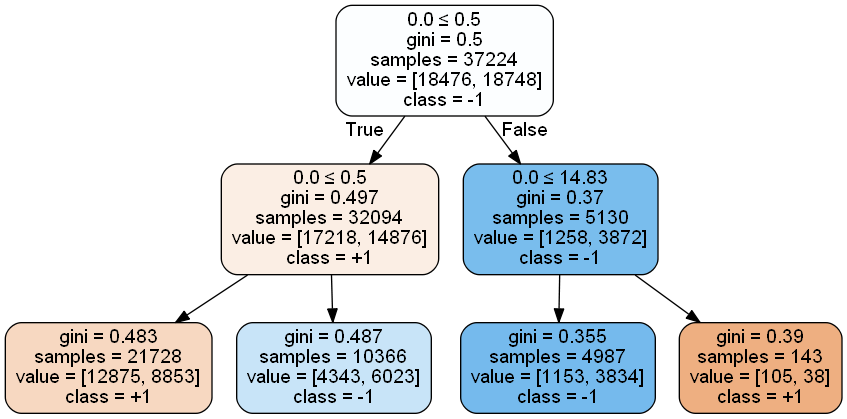

In [16]:
dot_data = tree.export_graphviz(small_model, out_file='simple_tree_small.dot',
                               feature_names=sample_validation_data.drop('safe_loans', axis=1).iloc[1],  
                         class_names=['+1','-1'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
system("dot -Tpng simple_tree_small.dot -o simple_tree_small.png")



# The code below is to answer the following quiz question

'''This is to confirm that the prediction for sample_validation_data.iloc[1] is IN FACT -1'''
confirm = small_model.predict(np.array(sample_validation_data.drop('safe_loans',axis=1).iloc[1]).reshape(1,-1))
print('The prediction for sample_validation_data.iloc[1] is', *confirm, '\n\n')

Image(filename='simple_tree_small.png')

<font color='steelblue'><b> Quiz : Based on the visualized tree, what prediction would you make for this data point (according to small_model)?  </b></font>

<font color='mediumvioletred'><b> Answer : The prediction for sample_validation_data.iloc[1] is -1 </b></font>

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the **small_model** and **decision_tree_model** on the training data

In [17]:
decision_tree_model_train_accuracy = round(decision_tree_model.score(train_matrix,train_label),2)
small_model_train_accuracy = round(small_model.score(train_matrix,train_label),2)

print('The accuracy of the decision_tree_model on the train data is : ', decision_tree_model_train_accuracy)
print('The accuracy of the small_model on the train data is : ', small_model_train_accuracy)

The accuracy of the decision_tree_model on the train data is :  0.64
The accuracy of the small_model on the train data is :  0.61


**Checkpoint:** You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

In [18]:
validation_matrix = validation_data.drop('safe_loans', axis=1)
validation_label = validation_data['safe_loans'].to_numpy() 

decision_tree_model_validation_accuracy = round(decision_tree_model.score(validation_matrix,validation_label),2)
small_model_validation_accuracy = round(small_model.score(validation_matrix,validation_label),2)

print('The accuracy of the decision_tree_model on the validation data is : ', decision_tree_model_validation_accuracy)
print('The accuracy of the small_model on the validation data is : ', small_model_validation_accuracy)

The accuracy of the decision_tree_model on the validation data is :  0.64
The accuracy of the small_model on the validation data is :  0.62


<font color='steelblue'><b> Quiz : What is the accuracy of decision_tree_model on the validation set, rounded to the nearest .01?  </b></font>

<font color='mediumvioletred'><b> Answer : The accuracy of the decision_tree_model on the validation data is : {{decision_tree_model_validation_accuracy}} </b></font>

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with **max_depth=10**. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

Using sklearn.tree.DecisionTreeClassifier, train a decision tree with maximum depth = 10. Call this model **big_model**.

In [19]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model = big_model.fit(train_matrix,train_label)

 Evaluate the accuracy of **big_model** on the training set and validation set.

In [20]:
big_model_train_accuracy = round(big_model.score(train_matrix, train_label),2)
big_model_validation_accuracy = round(big_model.score(validation_matrix, validation_label),2)

print('The accuracy of the big_model on the validation data is : ', big_model_train_accuracy)
print('The accuracy of the big_model on the validation data is : ', big_model_validation_accuracy)

'''Checkpoint'''
if big_model_train_accuracy > decision_tree_model_train_accuracy :
    print('\nCheckpoint : The big_model performs even better on training set than decision_tree_model\n')
elif big_model_train_accuracy > decision_tree_model_train_accuracy :
    print('\nCheckpoint : The big_model does not performs better on training set than decision_tree_model\n')
    
# The code below is to answer the following quiz question
if big_model_validation_accuracy > decision_tree_model_train_accuracy :
    answer = 'big_model has higher accuracy on the validation set than decision_tree_model. This is overfitting.'
    
elif big_model_validation_accuracy < decision_tree_model_train_accuracy :
    answer = 'big_model has lower accuracy on the validation set than decision_tree_model. This is not overfitting.'
    
print(answer)

The accuracy of the big_model on the validation data is :  0.66
The accuracy of the big_model on the validation data is :  0.63

Checkpoint : The big_model performs even better on training set than decision_tree_model

big_model has lower accuracy on the validation set than decision_tree_model. This is not overfitting.


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

<font color='steelblue'><b> Quiz : How does the performance of big_model on the validation set compare to decision_tree_model on the validation set? Is this a sign of overfitting? </b></font>

<font color='mediumvioletred'><b> Answer : {{answer}} </b></font>

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

In [21]:
decision_tree_model_validation_predicitions = decision_tree_model.predict(validation_matrix)

decision_tree_model_validation_fp = 0
decision_tree_model_validation_fn = 0

for prediction, actual in zip(decision_tree_model_validation_predicitions, validation_label) :
    if prediction == 1 and actual == -1 :
        decision_tree_model_validation_fp += 1
    else :
        decision_tree_model_validation_fp += 0
        
for prediction, actual in zip(decision_tree_model_validation_predicitions, validation_label) :
    if prediction == -1 and actual == +1 :
        decision_tree_model_validation_fn += 1
    else :
        decision_tree_model_validation_fn += 0

decision_tree_model_validation_mistakes = decision_tree_model_validation_fp + decision_tree_model_validation_fn
        
print('Number of False Positives in decision_tree_model : ', decision_tree_model_validation_fp)
print('Number of False Negatives in decision_tree_model : ', decision_tree_model_validation_fn)
print('Number of mistakes made by decision_tree_model   : ', decision_tree_model_validation_mistakes)


# The code below is to answer the following quiz question

cost = (10000 * decision_tree_model_validation_fn) + (20000 * decision_tree_model_validation_fp)
print('\nThe cost of the decision_tree_model on validation_data is : $',cost)

Number of False Positives in decision_tree_model :  1661
Number of False Negatives in decision_tree_model :  1717
Number of mistakes made by decision_tree_model   :  3378

The cost of the decision_tree_model on validation_data is : $ 50390000


<font color='steelblue'><b> Quiz : Let's assume that each mistake costs us money: a false negative costs \\$10,000 while a false positive costs \\$20,000. What is the total cost of mistakes made by decision_tree_model on validation_data? </b></font>

<font color='mediumvioletred'><b> Answer : The cost of the decision_tree_model on validation_data is : \\${{cost}} </b></font>